### Multiclass Support Vector Machines
In this exercise you will:
- implement a fully-vectorized loss function for the mulri-class SVM
- implement the fully-vectorized expression for its analytic gradient
- check your implementation using numerical gradient
- use a validation set to tune the learning rate and regularization strength
- optimize the loss function with SGD
- visualize the final learned parameters

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### CIFAR-10 Data Loading and Preprocessing
Open up a terminal window and navigate to the datasets folder inside the hw3 folder. Run the get_datasets.sh script. On my Mac, I just type in ./get_datasets.sh at the shell prompt. A new folder called cifar_10_batches_py will be created and it will contain 50000 labeled images for training and  10000 labeled images for testing. The function further partitions the  50000 training images into a train set and a validation set for selection of hyperparameters. We have provided a function to read this data in **data_utils.py**. Each image is a  32×32
array of RGB triples. It is preprocessed by subtracting the mean image from all images. We flatten each image into a 1-dimensional array of size 3072 (i.e.,  32×32×3). Then a 1 is appended to the front of that vector to handle the intercept term. So the training set is a numpy matrix of size  49000×3073, the validation set is a matrix of size  1000×3073 and the set-aside test set is of size  10000×3073. We also have a random sample of 500 images from the training data to serve as a development set or dev set to test our gradient and loss function implementations.

In [2]:
import data_utils

# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_dev, y_dev, X_test, y_test = data_utils.get_CIFAR10_data()

Train data shape:  (49000L, 32L, 32L, 3L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 32L, 32L, 3L)
Validation labels shape:  (1000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)
Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (10000L, 3072L)
dev data shape:  (500L, 3072L)
Training data shape with bias term:  (49000L, 3073L)
Validation data shape with bias term:  (1000L, 3073L)
Test data shape with bias term:  (10000L, 3073L)
Devset data shape with bias term:  (500L, 3073L)


### SVM Classifier
Your code for this section will all be written inside **linear_svm.py**.
As you can see, we have prefilled the function **naive_loss_svm** which uses for loops to evaluate the multiclass SVM loss function.

In [3]:
# Evaluate the naive implementation of the loss we provided for you:
from linear_svm import svm_loss_naive
import time


# generate a random SVM coefficient matrix of small numbers
theta = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(theta, X_train, y_train, 0.00001)
print 'loss: %f' % (loss, )
print 'grad: ', grad

loss: 9.228169
grad:  [[ -7.38160145e+00  -1.28701328e+01   7.53082614e+00 ...,  -2.99500318e+00
   -1.54972439e+01  -4.02445704e+01]
 [ -1.65919192e+01  -8.96090654e+00   6.89834517e+00 ...,  -3.93571196e+00
   -2.64315195e+01  -4.50290054e+01]
 [ -3.50388576e+01  -1.02511171e+01   1.90934917e+01 ...,  -3.20295733e+00
   -4.55967174e+01  -5.64105001e+01]
 ..., 
 [ -7.91742113e+00  -7.97544628e+00   1.70976880e+00 ...,  -9.79131795e+00
    1.50206234e+01  -1.05688470e+01]
 [ -2.04110472e+01  -1.42178427e+01   9.31703117e+00 ...,   5.00195155e+00
   -4.30640838e+00  -1.47429473e+01]
 [  6.14081624e-02  -1.38775528e-02  -3.44897939e-03 ...,   1.24489866e-03
   -5.10204465e-04  -2.93469376e-02]]


The grad returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function **svm_loss_naive**. You will find it helpful to interleave your new code inside the existing function.
To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you.

In [4]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at theta.
loss, grad = svm_loss_naive(theta, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from gradient_check import grad_check_sparse
f = lambda th: svm_loss_naive(th, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, theta, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(theta, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(theta, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, theta, grad)

numerical: 25.430768 analytic: 25.459556, relative error: 5.656877e-04
numerical: -12.923890 analytic: -12.923890, relative error: 1.173005e-11
numerical: -43.242778 analytic: -43.242778, relative error: 3.100948e-12
numerical: -8.832197 analytic: -8.843808, relative error: 6.568533e-04
numerical: -23.965594 analytic: -23.965594, relative error: 3.108418e-12
numerical: -12.644692 analytic: -12.644692, relative error: 1.359736e-11
numerical: -6.520626 analytic: -6.520626, relative error: 1.573879e-11
numerical: 17.117807 analytic: 17.117807, relative error: 1.988197e-11
numerical: 4.051941 analytic: 4.051941, relative error: 8.061849e-11
numerical: -5.036391 analytic: -5.036391, relative error: 1.056623e-11
numerical: -1.309350 analytic: -1.309350, relative error: 3.119786e-10
numerical: 41.041475 analytic: 41.041475, relative error: 1.271547e-11
numerical: -40.296737 analytic: -40.296737, relative error: 8.812325e-12
numerical: -72.442401 analytic: -72.448291, relative error: 4.065297e

In [5]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 9.211618e+00 computed in 0.700000s
Vectorized loss: 9.211618e+00 computed in 0.010000s
difference: -0.000000


### Vectorized version of the gradient computation
Complete the implementation of svm_loss_vectorized, and compute the gradient
of the loss function in a vectorized way.



In [6]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.795000s
Vectorized loss and gradient: computed in 0.010000s
difference: 0.000000


In [7]:
# In the file linear_classifier.py, we have implemented SGD in the function
# LinearClassifier.train() and you can run it with the code below.
from linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True, step=100)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 798.450206
iteration 100 / 1500: loss 290.954582
iteration 200 / 1500: loss 109.126754
iteration 300 / 1500: loss 43.003484
iteration 400 / 1500: loss 18.978234
iteration 500 / 1500: loss 10.248598
iteration 600 / 1500: loss 7.073362
iteration 700 / 1500: loss 5.917242
iteration 800 / 1500: loss 5.495873
iteration 900 / 1500: loss 5.342181
iteration 1000 / 1500: loss 5.286082
iteration 1100 / 1500: loss 5.265604
iteration 1200 / 1500: loss 5.258123
iteration 1300 / 1500: loss 5.255388
iteration 1400 / 1500: loss 5.254386
That took 1073.913000s


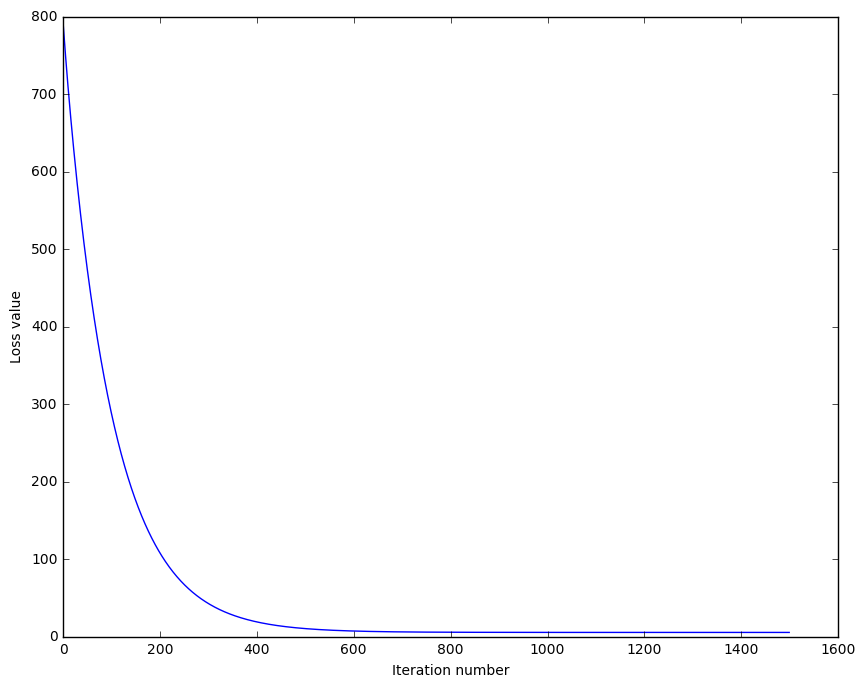

In [8]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Prediction with an SVM
Compute $\theta^T  x$ for a new example $x$ and pick the class with the highest score.

In [9]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.377551
validation accuracy: 0.383000


In [8]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-7, 1e-6, 5e-5]
regularization_strengths = [1e4, 5e4, 1e5, 5e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

best_lamda=learning_rates[0]
best_reg=regularization_strengths[0]

for lamda in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, lamda, reg, num_iters=500, verbose=True, step=100)
        y_val_pred = svm.predict(X_val)
        accuracy_val=np.mean(y_val == y_val_pred)
        y_train_pred=svm.predict(X_train)
        accuracy_train=np.mean(y_train == y_train_pred)
        results[(lamda, reg)] = (accuracy_train, accuracy_val)
        if accuracy_val>best_val:
            best_lamda=lamda
            best_reg=reg
            best_val=accuracy_val
            best_svm=svm
        print "When learning rate = {}, regularication length = {},  validation accuracy = {}".format(lamda, reg, accuracy_val)
        print("-"*70)
            

iteration 0 / 500: loss 174.227873
iteration 100 / 500: loss 135.417492
iteration 200 / 500: loss 110.462474
iteration 300 / 500: loss 90.617781
iteration 400 / 500: loss 74.586957
When learning rate = 1e-07, regularication length = 10000.0,  validation accuracy = 0.304
----------------------------------------------------------------------
iteration 0 / 500: loss 777.247402
iteration 100 / 500: loss 283.759340
iteration 200 / 500: loss 106.513253
iteration 300 / 500: loss 42.071727
iteration 400 / 500: loss 18.647583
When learning rate = 1e-07, regularication length = 50000.0,  validation accuracy = 0.379
----------------------------------------------------------------------
iteration 0 / 500: loss 1563.912358
iteration 100 / 500: loss 211.716074
iteration 200 / 500: loss 32.866561
iteration 300 / 500: loss 9.201387
iteration 400 / 500: loss 6.064939
When learning rate = 1e-07, regularication length = 100000.0,  validation accuracy = 0.38
-----------------------------------------------

linear_svm.py:151: RuntimeWarning: overflow encountered in double_scalars
  J += 0.5 * reg * np.sum(theta * theta)
linear_svm.py:151: RuntimeWarning: overflow encountered in multiply
  J += 0.5 * reg * np.sum(theta * theta)


iteration 300 / 500: loss inf
iteration 400 / 500: loss inf
When learning rate = 5e-05, regularication length = 100000.0,  validation accuracy = 0.065
----------------------------------------------------------------------
iteration 0 / 500: loss 7623.821313
iteration 100 / 500: loss 8408818720402195951333840246929648874038056836576299729384982745383224190039069352480302205033514844848371630803390807820638777714824406890883965317403064571153207700502693842228369630228553151760960794555856140102739379553160218383366164366853170832830379720563666572169195814912.000000
iteration 200 / 500: loss inf


linear_svm.py:174: RuntimeWarning: overflow encountered in multiply
  dtheta = dtheta + reg*theta
linear_svm.py:146: RuntimeWarning: invalid value encountered in subtract
  margin = np.maximum(0, scores - correct_class_score[np.newaxis].T + delta)
linear_svm.py:146: RuntimeWarning: invalid value encountered in maximum
  margin = np.maximum(0, scores - correct_class_score[np.newaxis].T + delta)
linear_svm.py:167: RuntimeWarning: invalid value encountered in greater
  num_yi = np.sum(margin>0 , axis=1)
linear_svm.py:169: RuntimeWarning: invalid value encountered in greater
  temp[margin>0] = 1
linear_classifier.py:50: RuntimeWarning: invalid value encountered in subtract
  self.theta = self.theta - learning_rate * grad


iteration 300 / 500: loss nan
iteration 400 / 500: loss nan
When learning rate = 5e-05, regularication length = 500000.0,  validation accuracy = 0.087
----------------------------------------------------------------------


In [12]:
print "Best learning rate = {}, best regularication length = {},  best validation accuracy = {}".format(best_lamda, best_reg, best_val)
print("-"*70)

best_svm = LinearSVM()
best_loss_hist = best_svm.train(X_train, y_train, best_lamda, best_reg, num_iters=2000, verbose=True, step=200)
y_val_pred = best_svm.predict(X_val)
best_val_cal=np.mean(y_val == y_val_pred)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val_cal

Best learning rate = 5e-07, best regularication length = 10000.0,  best validation accuracy = 0.403
----------------------------------------------------------------------
iteration 0 / 2000: loss 178.078193
iteration 200 / 2000: loss 24.994391
iteration 400 / 2000: loss 7.299437
iteration 600 / 2000: loss 5.025323
iteration 800 / 2000: loss 4.728560
iteration 1000 / 2000: loss 4.689480
iteration 1200 / 2000: loss 4.684305
iteration 1400 / 2000: loss 4.683616
iteration 1600 / 2000: loss 4.683612
iteration 1800 / 2000: loss 4.683575
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.287347 val accuracy: 0.304000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.369306 val accuracy: 0.379000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.363878 val accuracy: 0.380000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.326265 val accuracy: 0.343000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.397939 val accuracy: 0.403000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.377490 

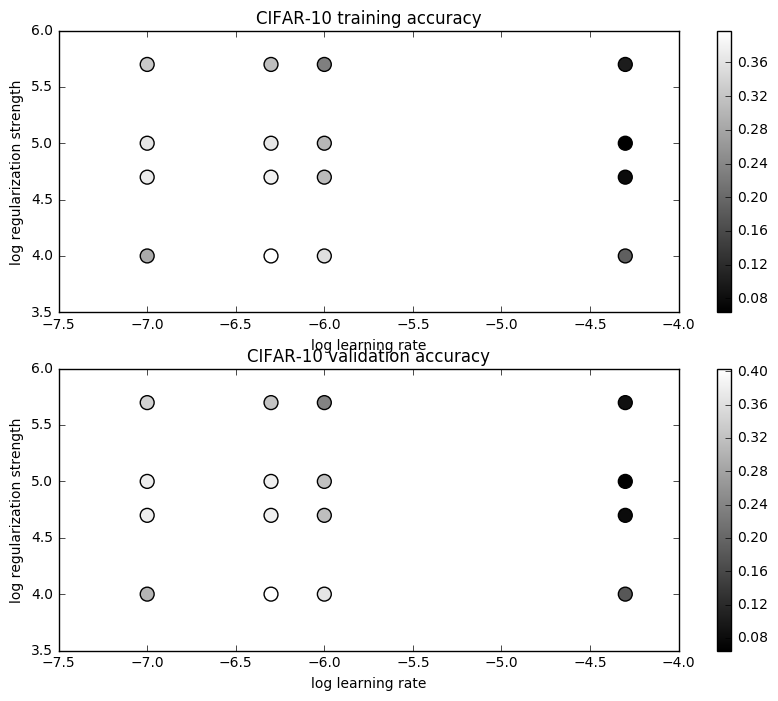

In [13]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [14]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.393300


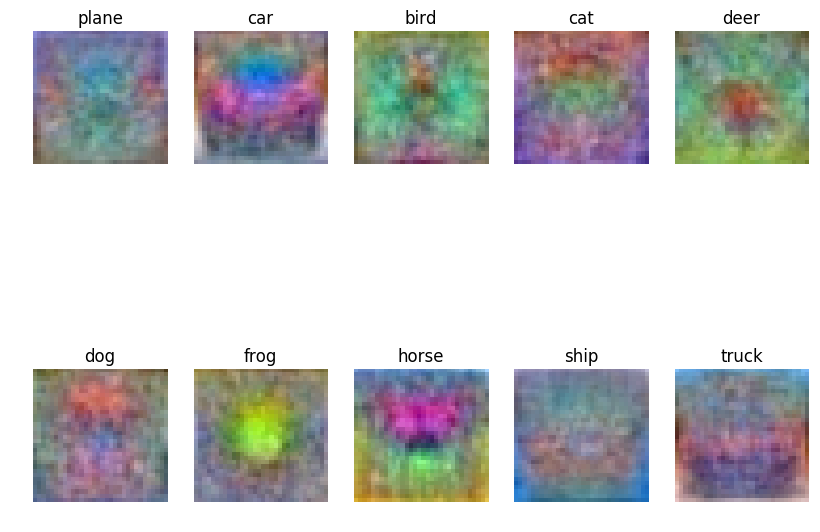

In [15]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.

theta = best_svm.theta[:-1,:] # strip out the bias
#theta = svm.theta[:-1,:]
theta = theta.reshape(32, 32, 3, 10)
theta_min, theta_max = np.min(theta), np.max(theta)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[:, :, :, i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])